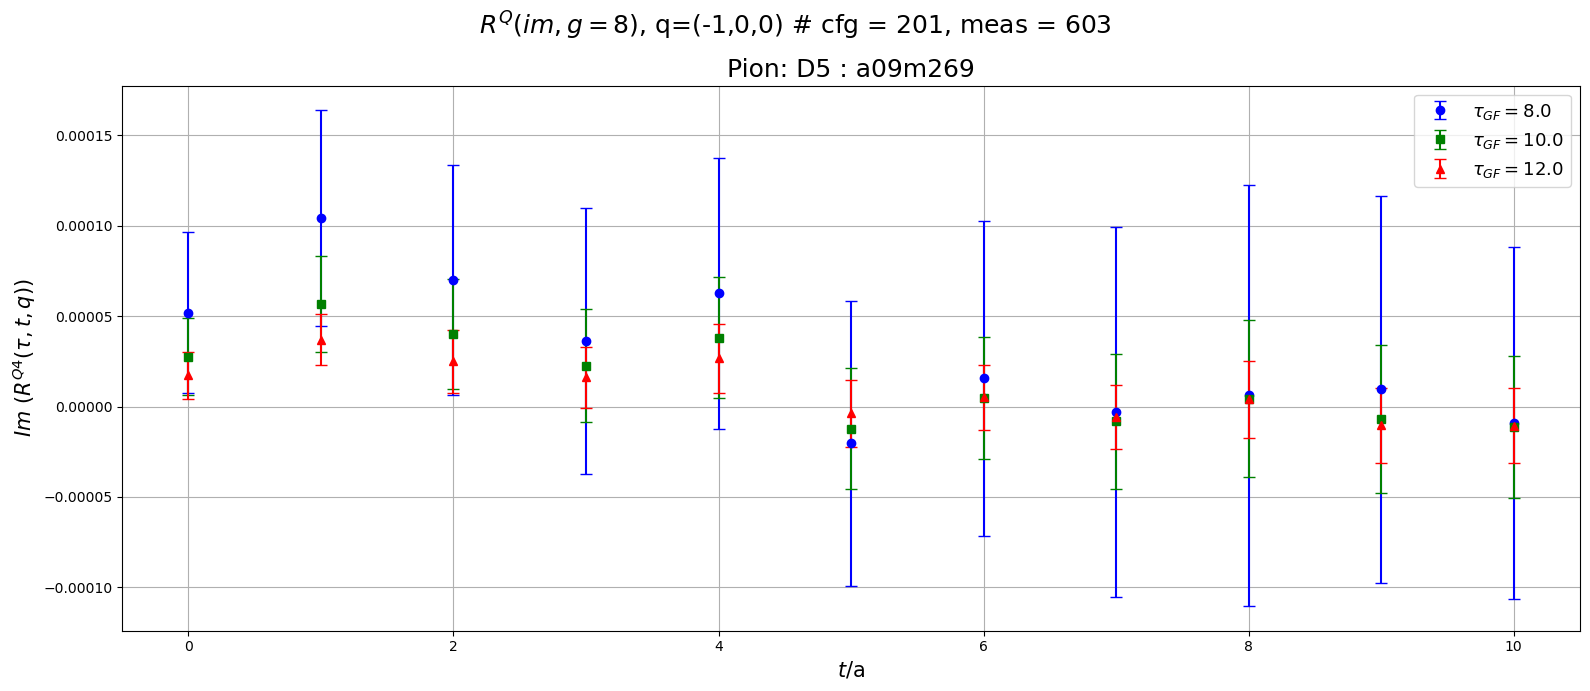

In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import pandas as pd

cfglist = (
    pd.read_csv("/pscratch/sd/h/hari_8/production_nEDM_LANL/config_numbers.txt", header=None, dtype=str)  # 1-column DataFrame
      .squeeze("columns")                                      # -> Series
      .tolist()                                                # -> Python list
)

def Jackknifeset(datalist): #this gives Jackknife set for given sent of values
    N = len(datalist)
    Jackknife_set = []
    for i in range(N): #Jackknife
        sliced_list = datalist[:(i)] + datalist[(i+1):]
        Jackknife_set.append(np.mean(sliced_list))
    return Jackknife_set
    
def Jackknife(datalist): #for given Jackknifeset
    N = len(datalist)
    theta_bar = np.mean(datalist)
    theta_nminus_theta_bar = []
    for i in range(len(datalist)): #Jackknife
        theta_n = datalist[(i)]
        theta_nminus_theta_bar.append(np.square(theta_n-theta_bar))
    sigma_sq = ((N-1)/N)*np.sum(theta_nminus_theta_bar)
    return(theta_bar, np.sqrt(sigma_sq))
    
def plot_all_flows(Gn, Num, snk_time, cfglist, qx):
    flow_times = [ "8p0", "12p5", "18p0"]
    tau_GF = [ 8.0, 12.5, 18]
    colors = ['blue', 'green', 'red', 'purple']
    markers = ['o', 's', '^', 'D']

    fig = plt.subplots(figsize=(16,7))

    for i, WFt in enumerate(flow_times):
        
        # Load 3pt data
        U_pt3_cfg = []
        D_pt3_cfg = []
        pprime_pt2_cfg = []
        p_pt2_cfg = []
        nocfg = 0
        for j, cfg in enumerate(cfglist):
            nocfg = nocfg+1
            tree = ET.parse(f"/pscratch/sd/h/hari_8/production_nEDM_LANL/output_gg_flow/out_qtop_ggg_allFLOW_cfg_{cfg}.xml")  
            root = tree.getroot()
            gg_values = []
            for elem in root.findall(".//Weinberg_GGG"):
               re_value = elem.find("qtop").text
               gg_values.append(float(re_value))


            gg = -np.array(gg_values)[i+1]
            U_file_path = f"/pscratch/sd/h/hari_8/production_nEDM_LANL/output_3pt2pt_flow/WF{WFt}_pion3pt_t{snk_time}_{cfg}.h5"
        
            with h5py.File(U_file_path, "r") as h5_file: 
                U_path_to_observable_cfgb = f"//NUCL_l0_g{Gn}_qz+0_qy+0_qx-{qx}/001"
                U_observable_cfgb = h5_file[U_path_to_observable_cfgb]
                U_values = U_observable_cfgb[Num][()]
            
            U_pt3_data = np.array(U_values)
            U_pt3_data1 = U_pt3_data[00:(00+(snk_time+1))]
            U_pt3_data2 = U_pt3_data[21:(21+(snk_time+1))]
            U_pt3_data3 = U_pt3_data[42:(42+(snk_time+1))]
            U_pt3_cfg.append(gg*(U_pt3_data1+U_pt3_data2+U_pt3_data3)/3)
        
            
        

            # Load 2pt data
            
            pt2_file_path = "/pscratch/sd/h/hari_8/production_nEDM_LANL/output_3pt2pt_flow/hadspec.h5"
        
            with h5py.File(pt2_file_path, "r") as h5_file: 
                pprime_pt2_path_to_observable_cfgb = f"//pion.D-2389.DG7_1.DG7_1.SS/{WFt}_had_{cfg}"
                pprime_pt2_observable_cfgb = h5_file[pprime_pt2_path_to_observable_cfgb]
                pprime_pt2_values = pprime_pt2_observable_cfgb["re"][()]
            pprime_pt2_data = np.array(pprime_pt2_values)
            pprime_pt2_data1 = pprime_pt2_data[0:(0+(snk_time+1))]
            pprime_pt2_data2 = pprime_pt2_data[21:(21+(snk_time+1))]
            pprime_pt2_data3 = pprime_pt2_data[42:(42+(snk_time+1))]
            pprime_pt2_cfg.append((pprime_pt2_data1+pprime_pt2_data2+pprime_pt2_data3)/3)

            with h5py.File(pt2_file_path, "r") as h5_file: 
                p_pt2_path_to_observable_cfgb = f"//pion_px{qx}_py0_pz0.D-2389.DG7_1.DG7_1.SS/{WFt}_had_{cfg}"
                p_pt2_observable_cfgb = h5_file[p_pt2_path_to_observable_cfgb]
                p_pt2_values = p_pt2_observable_cfgb["re"][()]
            p_pt2_data = np.array(p_pt2_values)
            p_pt2_data1 = p_pt2_data[0:(0+(snk_time+1))]
            p_pt2_data2 = p_pt2_data[21:(21+(snk_time+1))]
            p_pt2_data3 = p_pt2_data[42:(42+(snk_time+1))]
            p_pt2_cfg.append((p_pt2_data1+p_pt2_data2+p_pt2_data3)/3)

    
        # Compute jackknife
        tau = snk_time
        Cpt2_tau_pp_jackknifeset = Jackknifeset([pprime_pt2_cfg[i][(tau)] for i in range(len(pprime_pt2_cfg))])
        Cpt2_tau_p_jackknifeset = Jackknifeset([p_pt2_cfg[i][(tau)] for i in range(len(p_pt2_cfg))])
        
        pt3bypt2_JK_value = []
        pt3bypt2_JK_err = []
        pt3_JK_value = []
        pt3_JK_err = []
        pt2_JK_value = []
        pt2_JK_err = []
        for t in range(snk_time+1):
            U_tau_Jackknifeset = Jackknifeset([U_pt3_cfg[i][t] for i in range(len(U_pt3_cfg))])
            Cpt2_t_pp_jackknifeset = Jackknifeset([pprime_pt2_cfg[i][(t)] for i in range(len(pprime_pt2_cfg))])
            Cpt2_t_p_jackknifeset = Jackknifeset([p_pt2_cfg[i][(t)] for i in range(len(p_pt2_cfg))])
            Cpt2_tau_t_pp_jackknifeset = Jackknifeset([pprime_pt2_cfg[i][(tau-t)] for i in range(len(pprime_pt2_cfg))])
            Cpt2_tau_t_p_jackknifeset = Jackknifeset([p_pt2_cfg[i][(tau-t)] for i in range(len(p_pt2_cfg))])


            
            UDby2pt = (np.array(U_tau_Jackknifeset)) / np.array(Cpt2_tau_pp_jackknifeset)
            SQRT_FACTOR = np.sqrt((np.array(Cpt2_t_pp_jackknifeset)*np.array(Cpt2_tau_pp_jackknifeset)*np.array(Cpt2_tau_t_p_jackknifeset))/(np.array(Cpt2_t_p_jackknifeset)*np.array(Cpt2_tau_p_jackknifeset)*np.array(Cpt2_tau_t_pp_jackknifeset)))
            pt3bypt2_JK_value_err = Jackknife(UDby2pt*SQRT_FACTOR)
            

            
    
            pt3bypt2_JK_value.append(pt3bypt2_JK_value_err[0])
            pt3bypt2_JK_err.append(pt3bypt2_JK_value_err[1])



        # Final plot settings
        time_plt = np.arange(len(pt3bypt2_JK_value))
        plt.errorbar(time_plt, pt3bypt2_JK_value, yerr=pt3bypt2_JK_err, fmt=markers[i], markersize=6, capsize=4, color=colors[i], label=f"$\\tau_{{GF}} = {np.sqrt(8*tau_GF[i])}$")

    
    plt.xlabel("$t$/a", fontsize=15)
    plt.ylabel("$Im~(R^{Q4}(\\tau,t,q))$", fontsize=15)
    plt.suptitle("$R^{Q}(%s, g=%s)$, q=(-%s,0,0) # cfg = %s, meas = %s"%(Num, Gn, qx, nocfg, nocfg*3), fontsize=18  )
    plt.title("Pion: D5 : a09m269", fontsize=18  )
    plt.tick_params(labelsize=10)
    plt.grid(True)
    #plt.ylim(-0.0005, 0.004)
    plt.legend(fontsize=13)
    plt.tight_layout()
    plt.savefig(f"D5_Pion_ImG8_Nu_4meas_all_flows_t{snk_time}.pdf", dpi=500)
    plt.show()


plot_all_flows(8, "im", 10, cfglist, 1)

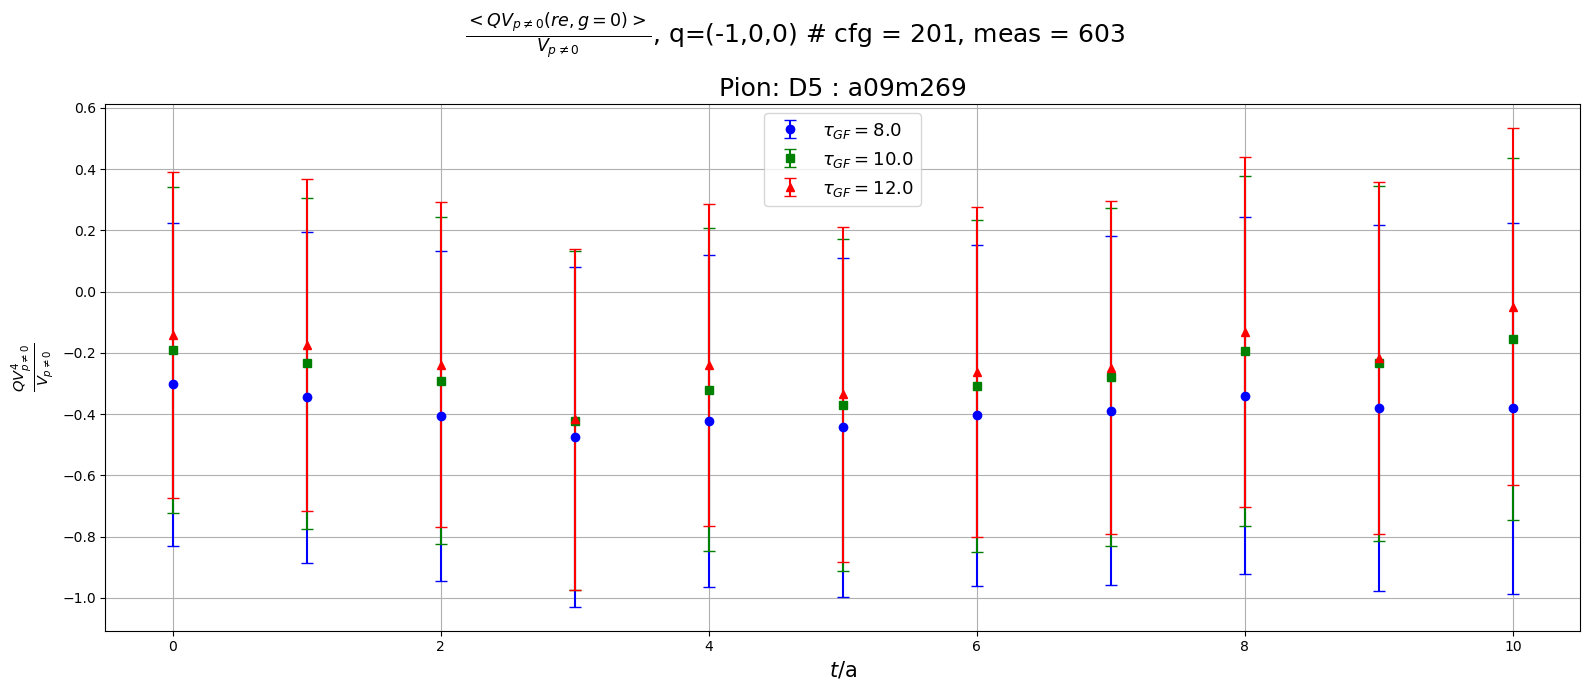

In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

def Jackknifeset(datalist): #this gives Jackknife set for given sent of values
    N = len(datalist)
    Jackknife_set = []
    for i in range(N): #Jackknife
        sliced_list = datalist[:(i)] + datalist[(i+1):]
        Jackknife_set.append(np.mean(sliced_list))
    return Jackknife_set
    
def Jackknife(datalist): #for given Jackknifeset
    N = len(datalist)
    theta_bar = np.mean(datalist)
    theta_nminus_theta_bar = []
    for i in range(len(datalist)): #Jackknife
        theta_n = datalist[(i)]
        theta_nminus_theta_bar.append(np.square(theta_n-theta_bar))
    sigma_sq = ((N-1)/N)*np.sum(theta_nminus_theta_bar)
    return(theta_bar, np.sqrt(sigma_sq))
    
def plot_all_flows(Gn, Num, snk_time, cfglist, qx):
    flow_times = [ "8p0", "12p5", "18p0"]
    tau_GF = [ 8.0, 12.5, 18]
    colors = ['blue', 'green', 'red', 'purple']
    markers = ['o', 's', '^', 'D']

    fig = plt.subplots(figsize=(16,7))

    for i, WFt in enumerate(flow_times):
        
        # Load 3pt data
        U_pt3_cfg = []
        D_pt3_cfg = []
        q0U_pt3_cfg = []
        q0D_pt3_cfg = []
        nocfg = 0
        for j, cfg in enumerate(cfglist):
            nocfg = nocfg+1
            tree = ET.parse(f"/pscratch/sd/h/hari_8/production_nEDM_LANL/output_gg_flow/out_qtop_ggg_allFLOW_cfg_{cfg}.xml")  
            root = tree.getroot()
            gg_values = []
            for elem in root.findall(".//Weinberg_GGG"):
               re_value = elem.find("qtop").text
               gg_values.append(float(re_value))


            gg = -np.array(gg_values)[i+1]
            U_file_path = f"/pscratch/sd/h/hari_8/production_nEDM_LANL/output_3pt2pt_flow/WF{WFt}_pion3pt_t{snk_time}_{cfg}.h5"
        
            with h5py.File(U_file_path, "r") as h5_file: 
                U_path_to_observable_cfgb = f"//NUCL_l0_g{Gn}_qz+0_qy+0_qx-{qx}/001"
                U_observable_cfgb = h5_file[U_path_to_observable_cfgb]
                U_values = U_observable_cfgb[Num][()]
            
            U_pt3_data = np.array(U_values)
            U_pt3_data1 = U_pt3_data[00:(00+(snk_time+1))]
            U_pt3_data2 = U_pt3_data[21:(21+(snk_time+1))]
            U_pt3_data3 = U_pt3_data[42:(42+(snk_time+1))]
            U_pt3_cfg.append(gg*(U_pt3_data1+U_pt3_data2+U_pt3_data3)/3)

            with h5py.File(U_file_path, "r") as h5_file: 
                q0U_path_to_observable_cfgb = f"//NUCL_l0_g{Gn}_qz+0_qy+0_qx-{qx}/001"
                q0U_observable_cfgb = h5_file[q0U_path_to_observable_cfgb]
                q0U_values = q0U_observable_cfgb[Num][()]
            
            q0U_pt3_data = np.array(q0U_values)
            q0U_pt3_data1 = q0U_pt3_data[00:(00+(snk_time+1))]
            q0U_pt3_data2 = q0U_pt3_data[21:(21+(snk_time+1))]
            q0U_pt3_data3 = q0U_pt3_data[42:(42+(snk_time+1))]
            q0U_pt3_cfg.append((q0U_pt3_data1+q0U_pt3_data2+q0U_pt3_data3)/3)
        
            

            

    
        # Compute jackknife
        tau = snk_time
        
        
        pt3bypt2_JK_value = []
        pt3bypt2_JK_err = []
        for t in range(snk_time+1):
            U_tau_Jackknifeset = Jackknifeset([U_pt3_cfg[i][t] for i in range(len(U_pt3_cfg))])
            q0U_tau_Jackknifeset = Jackknifeset([q0U_pt3_cfg[i][t] for i in range(len(q0U_pt3_cfg))])
            

            
            UDby2pt = (np.array(U_tau_Jackknifeset)) /(np.array(q0U_tau_Jackknifeset))
            
            pt3bypt2_JK_value_err = Jackknife(UDby2pt)
            

            
    
            pt3bypt2_JK_value.append(pt3bypt2_JK_value_err[0])
            pt3bypt2_JK_err.append(pt3bypt2_JK_value_err[1])



        # Final plot settings
        time_plt = np.arange(len(pt3bypt2_JK_value))
        plt.errorbar(time_plt, pt3bypt2_JK_value, yerr=pt3bypt2_JK_err, fmt=markers[i], markersize=6, capsize=4, color=colors[i], label=f"$\\tau_{{GF}} = {np.sqrt(8*tau_GF[i])}$")

    
    plt.xlabel("$t$/a", fontsize=15)
    plt.ylabel("$\\frac{QV^{4}_{p\\neq0}}{V_{p\\neq0}}$", fontsize=15)
    plt.suptitle("$\\frac{<QV_{p\\neq0}(%s, g=%s)>}{V_{p\\neq0}}$, q=(-%s,0,0) # cfg = %s, meas = %s"%(Num, Gn, qx, nocfg, nocfg*3), fontsize=18  )
    plt.tick_params(labelsize=10)
    plt.title("Pion: D5 : a09m269", fontsize=18  )
    plt.grid(True)
    plt.legend(fontsize=13)
    plt.tight_layout()
    plt.savefig(f"D5_Pion_QReG8np_by_ReG8np_Nu_4meas_all_flows_t{snk_time}.pdf", dpi=500)
    plt.show()


plot_all_flows(0, "re", 10, cfglist, 1)

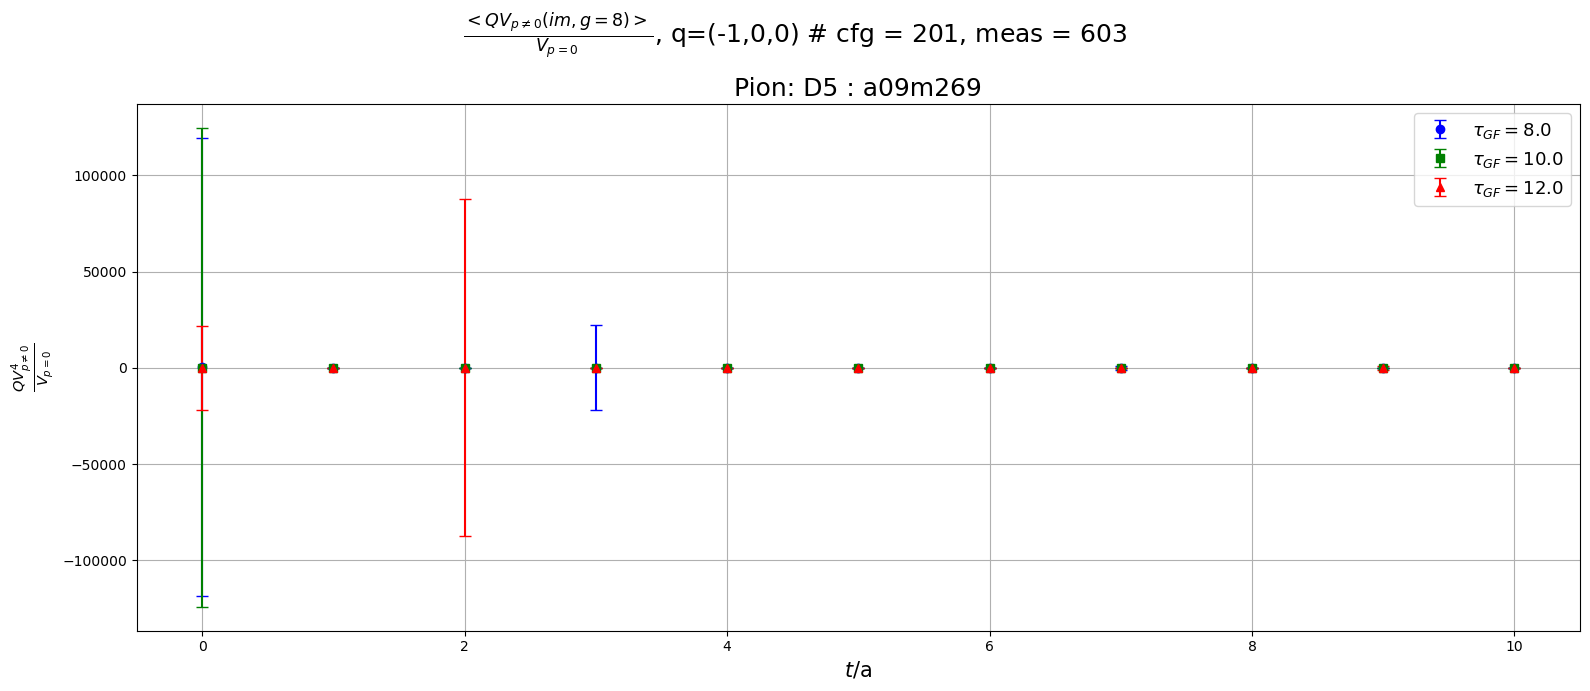

In [4]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

def Jackknifeset(datalist): #this gives Jackknife set for given sent of values
    N = len(datalist)
    Jackknife_set = []
    for i in range(N): #Jackknife
        sliced_list = datalist[:(i)] + datalist[(i+1):]
        Jackknife_set.append(np.mean(sliced_list))
    return Jackknife_set
    
def Jackknife(datalist): #for given Jackknifeset
    N = len(datalist)
    theta_bar = np.mean(datalist)
    theta_nminus_theta_bar = []
    for i in range(len(datalist)): #Jackknife
        theta_n = datalist[(i)]
        theta_nminus_theta_bar.append(np.square(theta_n-theta_bar))
    sigma_sq = ((N-1)/N)*np.sum(theta_nminus_theta_bar)
    return(theta_bar, np.sqrt(sigma_sq))
    
def plot_all_flows(Gn, Num, snk_time, cfglist, qx):
    flow_times = [ "8p0", "12p5", "18p0"]
    tau_GF = [ 8.0, 12.5, 18]
    colors = ['blue', 'green', 'red', 'purple']
    markers = ['o', 's', '^', 'D']

    fig = plt.subplots(figsize=(16,7))

    for i, WFt in enumerate(flow_times):
        
        # Load 3pt data
        U_pt3_cfg = []
        D_pt3_cfg = []
        q0U_pt3_cfg = []
        q0D_pt3_cfg = []
        nocfg = 0
        for j, cfg in enumerate(cfglist):
            nocfg = nocfg+1
            tree = ET.parse(f"/pscratch/sd/h/hari_8/production_nEDM_LANL/output_gg_flow/out_qtop_ggg_allFLOW_cfg_{cfg}.xml")  
            root = tree.getroot()
            gg_values = []
            for elem in root.findall(".//Weinberg_GGG"):
               re_value = elem.find("qtop").text
               gg_values.append(float(re_value))


            gg = -np.array(gg_values)[i+1]
            U_file_path = f"/pscratch/sd/h/hari_8/production_nEDM_LANL/output_3pt2pt_flow/WF{WFt}_pion3pt_t{snk_time}_{cfg}.h5"
        
            with h5py.File(U_file_path, "r") as h5_file: 
                U_path_to_observable_cfgb = f"//NUCL_l0_g{Gn}_qz+0_qy+0_qx-{qx}/001"
                U_observable_cfgb = h5_file[U_path_to_observable_cfgb]
                U_values = U_observable_cfgb[Num][()]
            
            U_pt3_data = np.array(U_values)
            U_pt3_data1 = U_pt3_data[00:(00+(snk_time+1))]
            U_pt3_data2 = U_pt3_data[21:(21+(snk_time+1))]
            U_pt3_data3 = U_pt3_data[42:(42+(snk_time+1))]
            U_pt3_cfg.append(gg*(U_pt3_data1+U_pt3_data2+U_pt3_data3)/3)

            with h5py.File(U_file_path, "r") as h5_file: 
                q0U_path_to_observable_cfgb = f"//NUCL_l0_g{Gn}_qz+0_qy+0_qx+0/001"
                q0U_observable_cfgb = h5_file[q0U_path_to_observable_cfgb]
                q0U_values = q0U_observable_cfgb[Num][()]
            
            q0U_pt3_data = np.array(q0U_values)
            q0U_pt3_data1 = q0U_pt3_data[00:(00+(snk_time+1))]
            q0U_pt3_data2 = q0U_pt3_data[21:(21+(snk_time+1))]
            q0U_pt3_data3 = q0U_pt3_data[42:(42+(snk_time+1))]
            q0U_pt3_cfg.append((q0U_pt3_data1+q0U_pt3_data2+q0U_pt3_data3)/3)
        
            
        

            

    
        # Compute jackknife
        tau = snk_time
        
        
        pt3bypt2_JK_value = []
        pt3bypt2_JK_err = []
        for t in range(snk_time+1):
            U_tau_Jackknifeset = Jackknifeset([U_pt3_cfg[i][t] for i in range(len(U_pt3_cfg))])
            q0U_tau_Jackknifeset = Jackknifeset([q0U_pt3_cfg[i][t] for i in range(len(q0U_pt3_cfg))])
            
            UDby2pt = (np.array(U_tau_Jackknifeset)) /(np.array(q0U_tau_Jackknifeset))
            
            pt3bypt2_JK_value_err = Jackknife(UDby2pt)
            

            
    
            pt3bypt2_JK_value.append(pt3bypt2_JK_value_err[0])
            pt3bypt2_JK_err.append(pt3bypt2_JK_value_err[1])



        # Final plot settings
        time_plt = np.arange(len(pt3bypt2_JK_value))
        plt.errorbar(time_plt, pt3bypt2_JK_value, yerr=pt3bypt2_JK_err, fmt=markers[i], markersize=6, capsize=4, color=colors[i], label=f"$\\tau_{{GF}} = {np.sqrt(8*tau_GF[i])}$")

    
    plt.xlabel("$t$/a", fontsize=15)
    plt.ylabel("$\\frac{QV^{4}_{p\\neq0}}{V_{p=0}}$", fontsize=15)
    plt.suptitle("$\\frac{<QV_{p\\neq0}(%s, g=%s)>}{V_{p=0}}$, q=(-%s,0,0) # cfg = %s, meas = %s"%(Num, Gn, qx, nocfg, nocfg*3), fontsize=18  )
    plt.tick_params(labelsize=10)
    plt.title("Pion: D5 : a09m269", fontsize=18  )
    plt.grid(True)
    plt.legend(fontsize=13)
    plt.tight_layout()
    plt.savefig(f"D5_Pion_QImG8np_by_ReG8p_4meas_all_flows_t{snk_time}.pdf", dpi=500)
    plt.show()


plot_all_flows(8, "im", 10, cfglist, 1)